##### This notebook plots the paths and timescales for water to reach the grounding line after entering the cavities

In [2]:
import numpy as np
from tqdm import tqdm
import zarr

from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import netCDF4 as nc
import h5py
import random

In [3]:
YG = np.load('inputs/ref/YG.npy')
XG = np.load('inputs/ref/XG.npy')
YC = np.load('inputs/ref/YC.npy')
XC = np.load('inputs/ref/XC.npy')
RF = np.load('inputs/ref/RF.npy')

IMF = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/2D/2D_2005_09C.nc')
y1 = np.argmin(abs(IMF['YG'] - YG[0]))
y2 = np.argmin(abs(IMF['YG'] - YG[-1]))
x1 = np.argmin(abs(IMF['XG'] - XG[0]%360))
x2 = np.argmin(abs(IMF['XG'] - XG[-1]%360))

In [4]:
icedraft = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/ICEDRAFT_v8.mat')
icedraft = icedraft['Ice_Map'][y1:y2+1,x1:x2+1]

grid = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/GRID_v8.mat')
bath = -grid['Depth'][:]
bath = bath[y1:y2+1,x1:x2+1] + icedraft
bath[bath==0] = np.nan
bath[bath<-2000] = np.nan

In [5]:
def get(zarr_path, var, exit_index_path):
    data = zarr.open(zarr_path, 'r')
    data = data[var]
    
    res = []
    
    exit = np.load(exit_index_path)
    
    for i in tqdm(range(len(exit))):
        if ~np.isnan(exit[i]):
            j = int(exit[i])
            res.append(data[i, j])
        else:
            res.append(np.nan)
            
    return np.asarray(res)

In [6]:
## t-index, theta, lon, lat, depth

def get_vals(zarr_path, exit_index_path):
    data = zarr.open(zarr_path, 'r')
    exit = np.load(exit_index_path)
    
    tindex = []
    
    traj_lon = []
    traj_lat = []
    traj_depth = []
    
    for i in tqdm(range(len(exit))):
#     for i in tqdm(range(1000)):
        if ~np.isnan(exit[i]):
            
            j = int(exit[i])
            if j < 365:
            
                tindex.append(j)
            
                traj_lon.append(data['lon'][i][:j+10])
                traj_lat.append(data['lat'][i][:j+10])
                traj_depth.append(data['z'][i][:j+10])
        
    return np.asarray(tindex), np.asarray(traj_lon), np.asarray(traj_lat), np.asarray(traj_depth)

In [7]:
def calc_cavity_flushing(paths, stucked, filt, IS, filt_val = None):
    data = np.load(paths)
    stucked = np.load(stucked)
    exit = np.load(IS)
    
    
    n = len(data)
    num = int(n/366)
    
    flush = []
    rates = []
    
    p05 = []
    p50 = []
    p95 = []
    
    for i in tqdm(range(0, n, num)):
        sub = data[i:i+num] ## Particles
        flags = stucked[i:i+num] ## Stucked particles in cavity

        if filt is None:
            sf = np.asarray([1 for _ in range(len(flags))])
            filt_val = 1
        else:
            sf = filt[i:i+num]
            
        ## Number of valid particle for analysis
        
        sub = sub[np.logical_and(sf==filt_val, flags==0)]

        n_sub = len(sub) ## Only particles of interest 
        n_tot = np.count_nonzero(np.logical_and(~np.isnan(sf), flags==0)) ## All particles that exited 
        
        p05.append(np.nanpercentile(sub, 5)) ## Percentile of particles of interest
        p50.append(np.nanpercentile(sub, 50))
        p95.append(np.nanpercentile(sub, 99))
    
        hist, _ = np.histogram(sub, np.arange(0,1100,1))
        exit_percent = np.asarray(np.cumsum(hist) / n_tot * 100) ## % of total particles
        f = np.asarray([v for v in exit_percent])
        r = np.asarray([np.count_nonzero(sub==v) for v in np.arange(0, 1095, 1)])
        
        if n_sub !=0: 
            r = r/n_sub*100
        else: ## If particles of interest is zero, then there's 0 rate
            r = 0
        
        rates.append(r)
        flush.append(f)
    
    print(f"Fastest 5% = {np.nanmean(p05)} +- {np.nanstd(p05)}")
    print(f"Median = {np.nanmean(p50)} +- {np.nanstd(p50)}")
    print(f"Slowest 5% = {np.nanmean(p95)} +- {np.nanstd(p95)}")
    
    return np.asarray(flush), np.asarray(rates)

# Pine Island

In [76]:
# tindex, lon, lat, depth = get_vals(zarr_path = 'outputs/R8_ASE_5min/pineisland.zarr',
#                                          exit_index_path = 'processed_dataGL/pineisland_0d_IS.npy')

# np.save("processed_exit_cavity/PIG_T.npy", tindex)
# np.save("processed_exit_cavity/PIG_X.npy", lon)
# np.save("processed_exit_cavity/PIG_Y.npy", lat)
# np.save("processed_exit_cavity/PIG_Z.npy", depth)

tindex = np.load("processed_exit_cavity/PIG_T.npy", allow_pickle=True)
lon = np.load("processed_exit_cavity/PIG_X.npy", allow_pickle=True)
lat = np.load("processed_exit_cavity/PIG_Y.npy", allow_pickle=True)
depth = np.load("processed_exit_cavity/PIG_Z.npy", allow_pickle=True)

In [77]:
Z = [i[-10] for i in depth]
T = [i for i in tindex]
X = [i[-10] for i in lon]
Y = [i[-10] for i in lat]
X2 = [i[-11] for i in lon]
Y2 = [i[-11] for i in lat]
Z2 = [i[-11] for i in depth]

In [78]:
np.nanmean(X2), np.nanmean(Y2), np.nanmean(Z2)

(-101.54728080842511, -75.05487729676611, -709.809170784876)

In [79]:
finalZ = [i[0] for i in depth]
np.mean(finalZ)

-1071.1925793426371

(-75.5, -74.1)

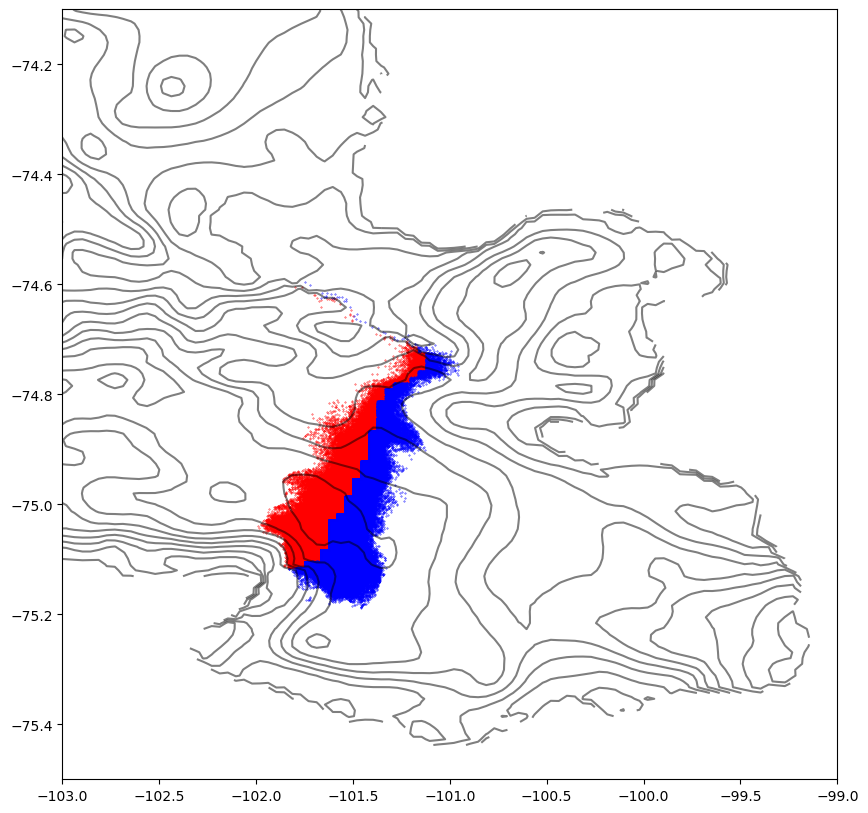

In [80]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(X, Y, s=0.1, c='red')

ax.scatter(X2, Y2, s=0.1, c='blue')

ax.contour(XC, YC, bath, levels=np.arange(-1600, 0, 100), colors=['k'], linestyles='solid', alpha=0.5, zorder=3)

ax.set_xlim(-103, -99)
ax.set_ylim(-75.5, -74.1)

In [81]:
mask = np.load('inputs/ref/PIG_Mask.npy')
pigmask = np.load('pig_mask.npy')

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1718.52it/s]


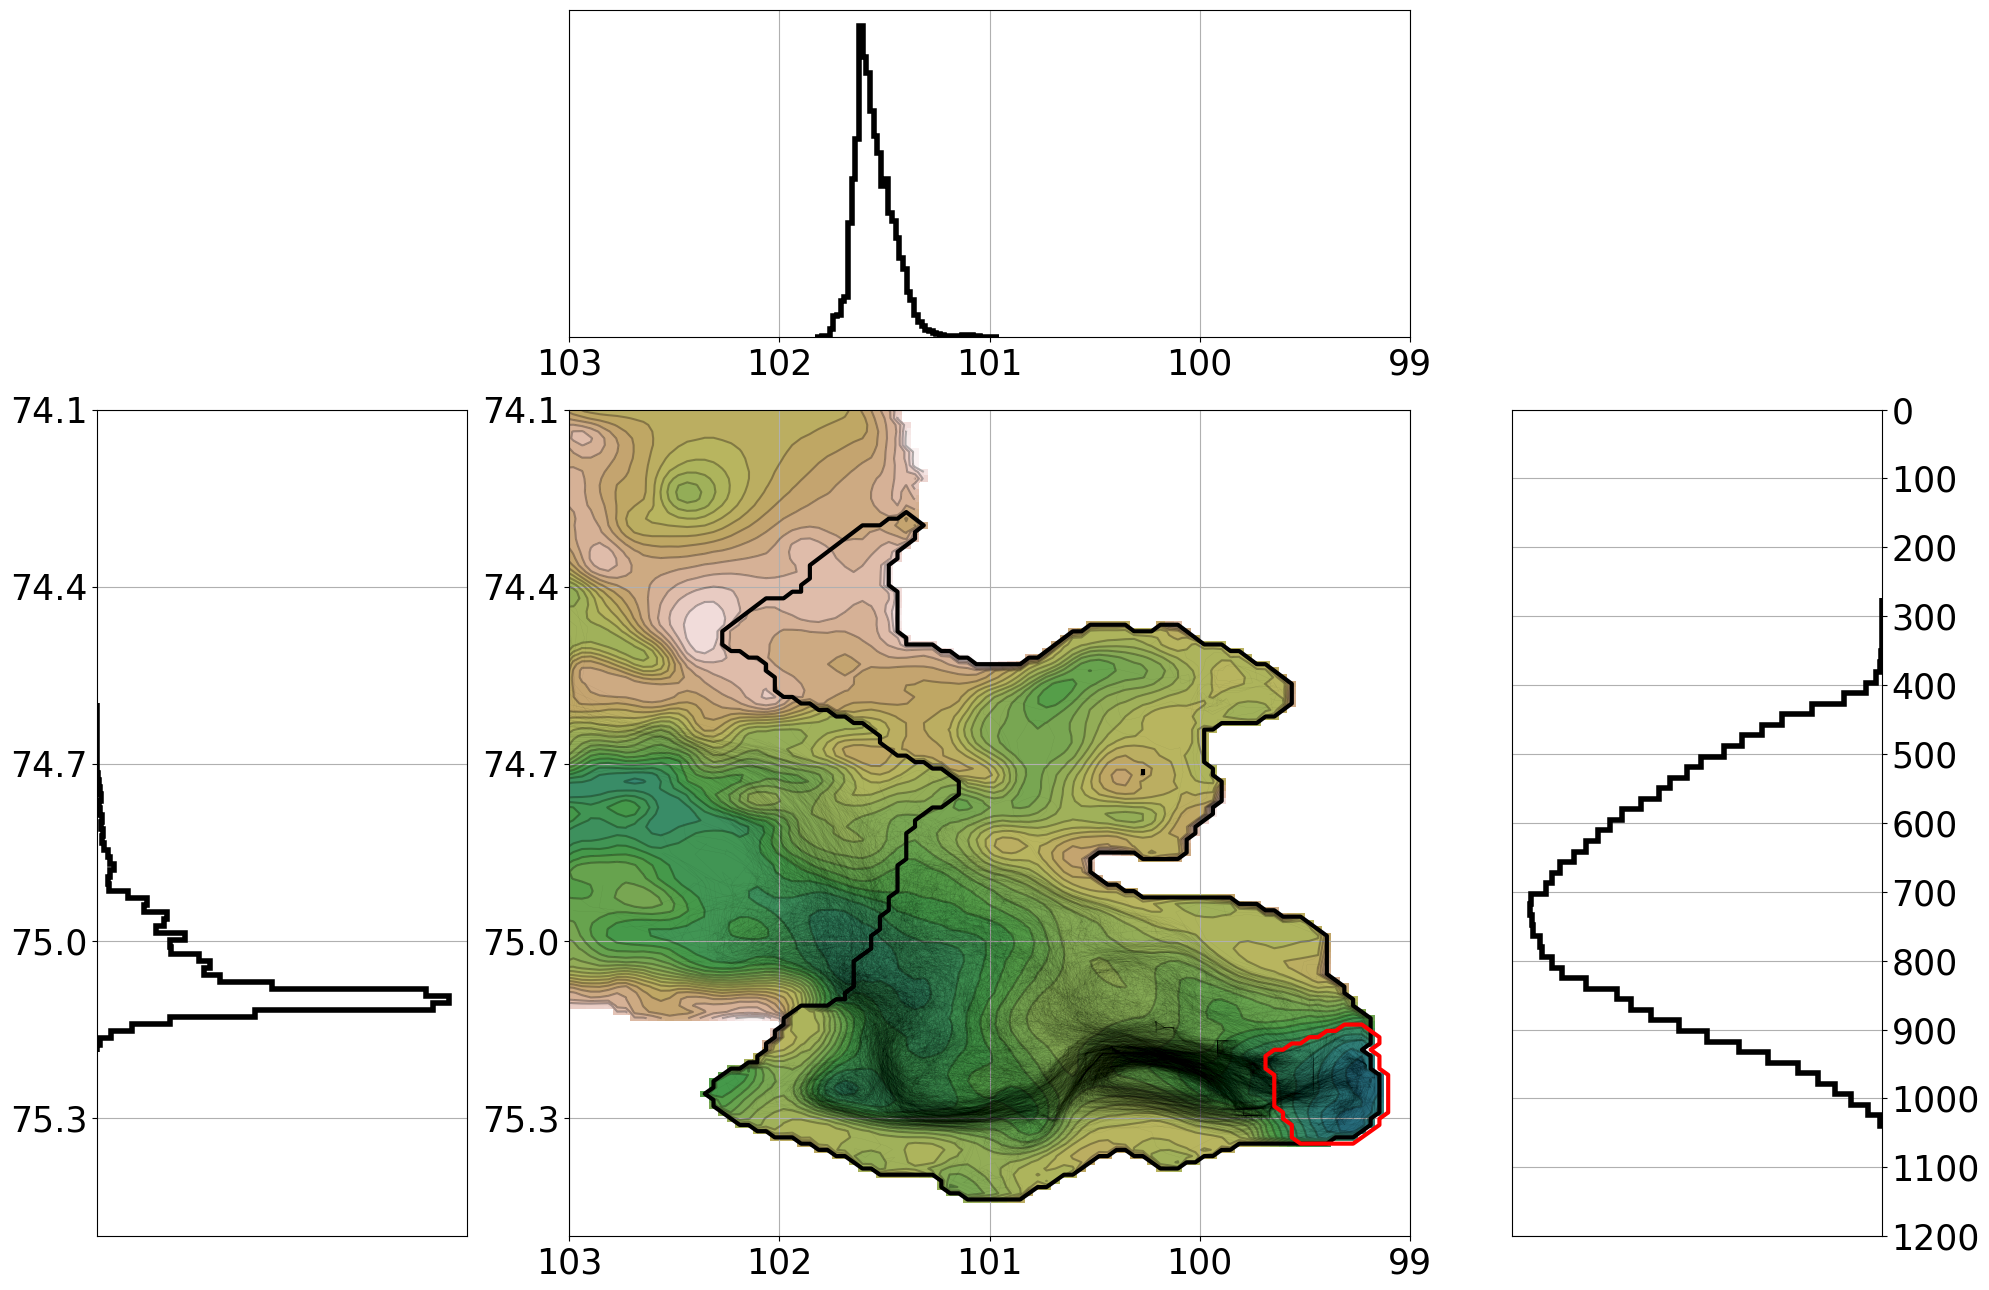

In [83]:
ls = 25

fig = plt.figure(figsize=(20, 13))

gs = gridspec.GridSpec(13, 16)
ax_main = plt.subplot(gs[4:, 4:12])
ax_xDist = plt.subplot(gs[0:4, 4:12],sharex=ax_main)
ax_yDist = plt.subplot(gs[4:13, :4],sharey=ax_main)
ax_zDist = plt.subplot(gs[4:13, 12:])

## Main Plot
ax_main.pcolormesh(XC, YC, bath, vmin=-1600, vmax=0, cmap='gist_earth')
ax_main.contourf(XC, YC, bath, levels=np.arange(-1601, 1, 50), cmap='gist_earth')
ax_main.contour(XC, YC, bath, levels=np.arange(-1601, 1, 50), colors=['k'], linestyles='solid', alpha=0.3, zorder=3)
ax_main.contour(XC, YC, mask, levels=[0,1], colors=['k'], linewidths=3)

ax_main.contour(XC, YC, pigmask, levels=[0,1], colors=['red'], linewidths=3,zorder=3)

ax_main.set_xticks([-103, -102, -101, -100, -99])
ax_main.set_xticklabels([103, 102, 101, 100, 99])

ax_main.set_yticks([-75.3, -75, -74.7, -74.4, -74.1])
ax_main.set_yticklabels([75.3, "75.0", 74.7, 74.4, 74.1])

ax_main.set_xlim(-103, -99)
ax_main.set_ylim(-75.5, -74.1)


ax_main.tick_params(axis='both', labelsize=ls)
ax_main.grid()

    
index = np.random.choice([i for i in range(len(lon))], size=1000, replace=False)

# for c in tqdm(range(len(index))):
    
#     i = index[c]
    
#     lx = lon[i][:]
#     ly = lat[i][:]
#     c = np.arange(len(lx))

#     lines = np.c_[lx[:-1], ly[:-1], lx[1:], ly[1:]]
#     lc = LineCollection(lines.reshape(-1, 2, 2), array=c, alpha = 0.1, linewidths=0.1, cmap = 'viridis_r')
#     ax.add_collection(lc)

for c in tqdm(range(len(index))):
    
    i = index[c]
    
    lx = lon[i][:]
    ly = lat[i][:]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='k', lw=0.1, alpha=0.2)
    
    
_, _, _ = ax_zDist.hist(Z2, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='horizontal', density = True, linewidth=4)
# _, _, _ = ax_zDist.hist(Z, 
#                         bins=50, alpha=0.5, histtype=u'step', ec='red', 
#                         orientation='horizontal', density = True, linewidth=4)
ax_zDist.tick_params(axis='both', labelsize=ls)
ax_zDist.invert_xaxis()
ax_zDist.yaxis.set_label_position("right")
ax_zDist.yaxis.tick_right()
ax_zDist.set_yticks([0, -100, -200, -300, -400, -500, -600, -700, -800, -900, -1000, -1100, -1200])
ax_zDist.set_yticklabels([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
ax_zDist.set_xticks([])
ax_zDist.grid()

_, _, _ = ax_yDist.hist(Y2, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='horizontal', density = True, linewidth=4)
# _, _, _ = ax_yDist.hist(Y, 
#                         bins=50, alpha=0.5, histtype=u'step', ec='red', 
#                         orientation='horizontal', density = True, linewidth=4)
ax_yDist.tick_params(axis='both', labelsize=ls)

ax_yDist.set_xticks([])
ax_yDist.grid()

_, _, _ = ax_xDist.hist(X2, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='vertical', density = True, linewidth=4)
# _, _, _ = ax_xDist.hist(X, 
#                         bins=50, alpha=0.5, histtype=u'step', ec='red', 
#                         orientation='vertical', density = True, linewidth=4)
ax_xDist.tick_params(axis='both', labelsize=ls)
ax_xDist.set_yticks([])
ax_xDist.grid()

plt.tight_layout()

plt.savefig('img_cavity_paths/PineIsland_Norm.png', dpi=300)

In [11]:
np.corrcoef(T, Z)

array([[1.        , 0.09078113],
       [0.09078113, 1.        ]])

In [17]:
flush, rate = calc_cavity_flushing(paths = 'processed_dataGL/pineisland_0d_IS.npy',
                   stucked = 'processed_dataGL/pineisland_0d_Stucked_incavity.npy',
                filt = None,
                IS = 'processed_dataGL/pineisland_0d_IS.npy')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 237.87it/s]

Fastest 5% = 20.376775956284153 +- 4.540469991930199
Median = 55.39344262295082 +- 14.236761107670235
Slowest 5% = 232.41459016393435 +- 24.176763880165606


In [18]:
fmean = np.mean(flush, axis=0)
fstd = np.std(flush, axis=0)

rmean = np.mean(rate, axis=0)
rstd = np.std(rate, axis=0)

print(f'% of total particles that exited: {fmean[-1]} +- {fstd[-1]}')

% of total particles that exited: 99.99971774375649 +- 0.005392497960569496


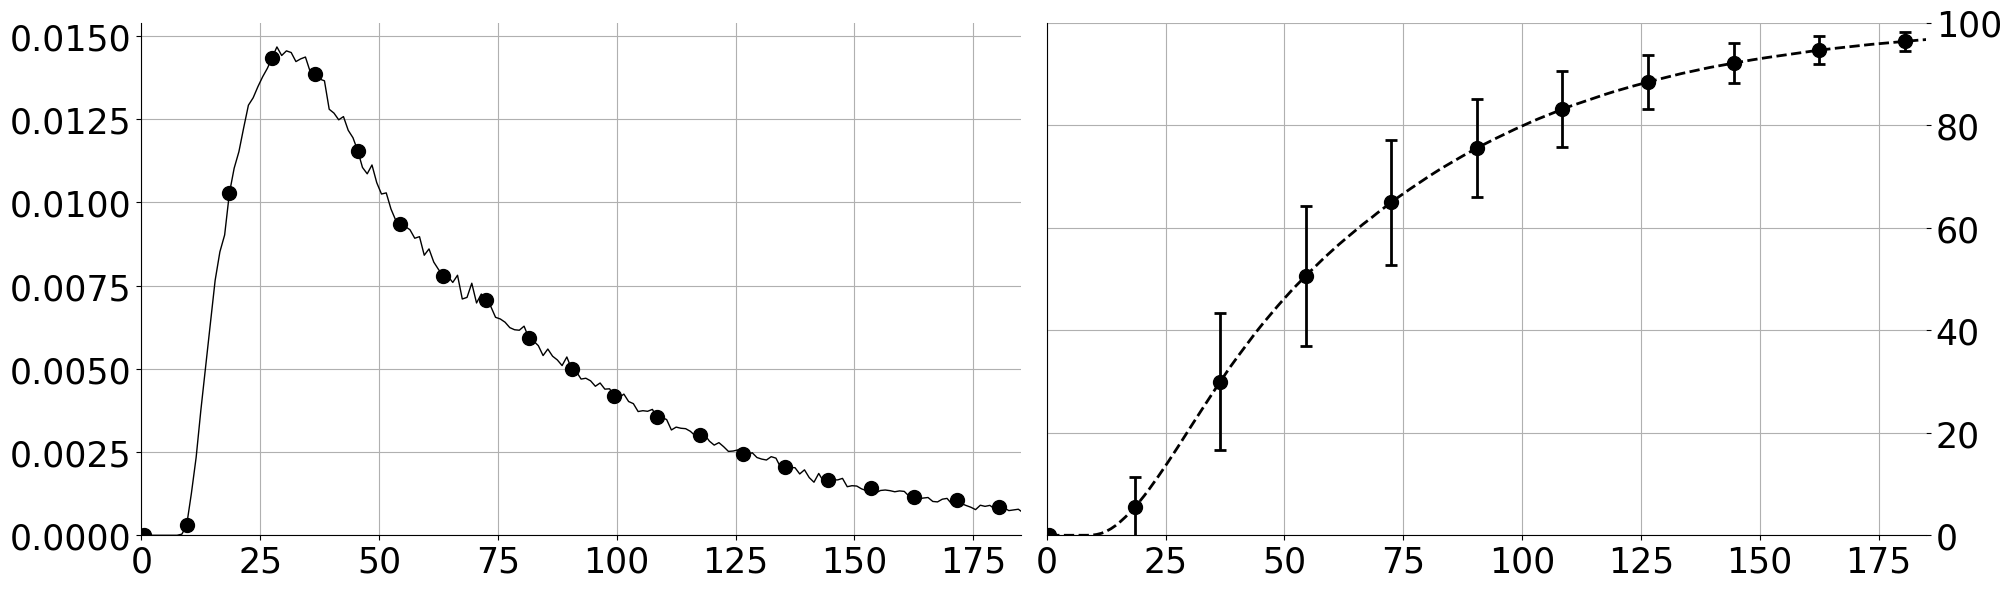

In [49]:
fig, ax = plt.subplots(figsize=(20,6), ncols=2)


ax[0].plot(np.arange(0.5, 364, 1),
        rmean[:364]/np.sum(rmean[:364]), '-k', lw=1, marker='o', ms=10, markevery=(0,9))


ax[1].errorbar(np.arange(0.5, 364, 1),
             fmean[:364], fmt = '--k',
             yerr=fstd[:364]/1,
            errorevery = (18),ecolor='k',marker='o', markevery=(18), ms=10, capsize=4, capthick=2, linewidth=2)

# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean1[:364], c= 'red')
# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean2[:364], c='blue')
# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean3[:364], c='k')


ax[0].set_ylim(0)
ax[1].set_ylim(0)
ax[0].set_xlim(0, 185)
ax[1].set_xlim(0, 185)
ax[1].set_ylim(0, 100)

ax[1].yaxis.tick_right()

for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.grid()
    a.tick_params(axis='both', labelsize=ls)
    
plt.tight_layout()

plt.savefig('img_cavity_paths/PineIsland_Time.png', dpi=300)

# Smith

In [84]:
# tindex, lon, lat, depth = get_vals(zarr_path = 'outputs/R8_ASE_5min/smith.zarr',
#                                          exit_index_path = 'processed_dataGL/smith_0d_IS.npy')

# np.save("processed_exit_cavity/smith_T.npy", tindex)
# np.save("processed_exit_cavity/smith_X.npy", lon)
# np.save("processed_exit_cavity/smith_Y.npy", lat)
# np.save("processed_exit_cavity/smith_Z.npy", depth)

tindex = np.load("processed_exit_cavity/smith_T.npy", allow_pickle=True)
lon = np.load("processed_exit_cavity/smith_X.npy", allow_pickle=True)
lat = np.load("processed_exit_cavity/smith_Y.npy", allow_pickle=True)
depth = np.load("processed_exit_cavity/smith_Z.npy", allow_pickle=True)

In [85]:
Z = [i[-10] for i in depth]
T = [i for i in tindex]
X = [i[-10] for i in lon]
Y = [i[-10] for i in lat]
X2 = np.asarray([i[-11] for i in lon])
Y2 = np.asarray([i[-11] for i in lat])
Z2 = np.asarray([i[-11] for i in depth])

In [86]:
np.nanmean(X2), np.nanmean(Y2), np.nanmean(Z2)

(-111.98644761374784, -74.30121529576844, -637.0244076423595)

In [87]:
finalZ = [i[0] for i in depth]
np.mean(finalZ)

-1289.7117631878157

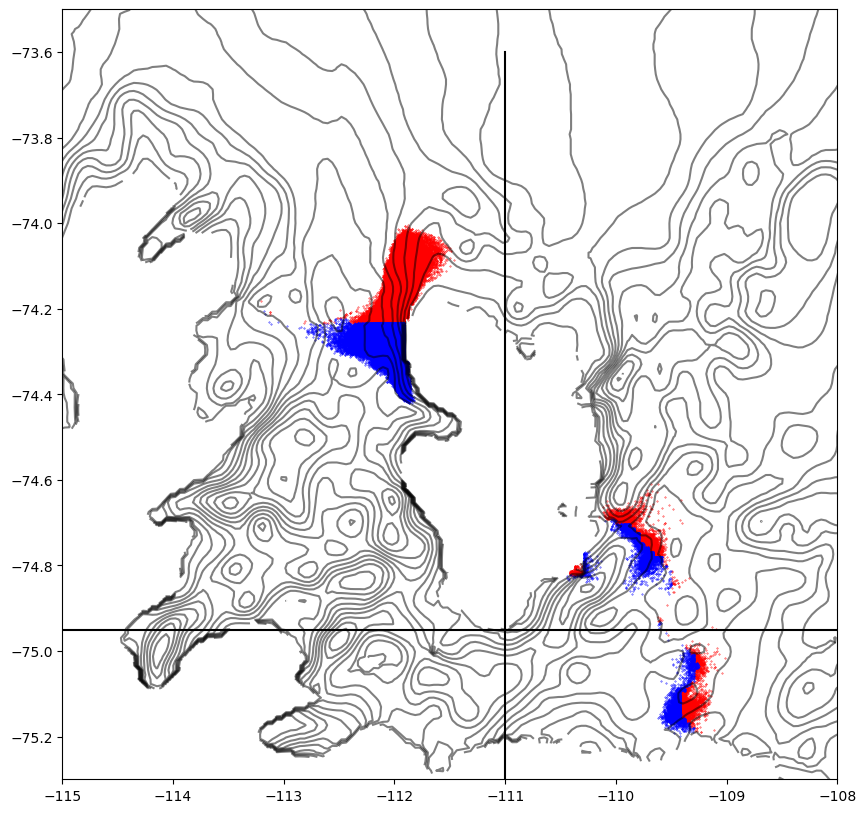

In [88]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(X, Y, s=0.1, c='red')

ax.scatter(X2, Y2, s=0.1, c='blue')

ax.contour(XC, YC, bath, levels=np.arange(-1600, 0, 100), colors=['k'], linestyles='solid', alpha=0.5, zorder=3)

ax.set_xlim(-115, -108)
ax.set_ylim(-75.3, -73.5)

ax.plot([-111, -111], [-75.3, -73.6], c='k')
ax.plot([-115, -108], [-74.95, -74.95], c='k')
# ax.plot([-109, -104], [-74.9, -74.9], c='k')

In [89]:
mask = np.load('inputs/ref/CSN_Mask.npy')
csnmask = np.load('csn_mask.npy')
csnmask[38:, :] = 0

In [90]:
classify = []

for i in range(len(Y)):
    if X[i] < -111:
        classify.append(1)
    else:
        classify.append(2)

classify = np.asarray(classify)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3336.46it/s]


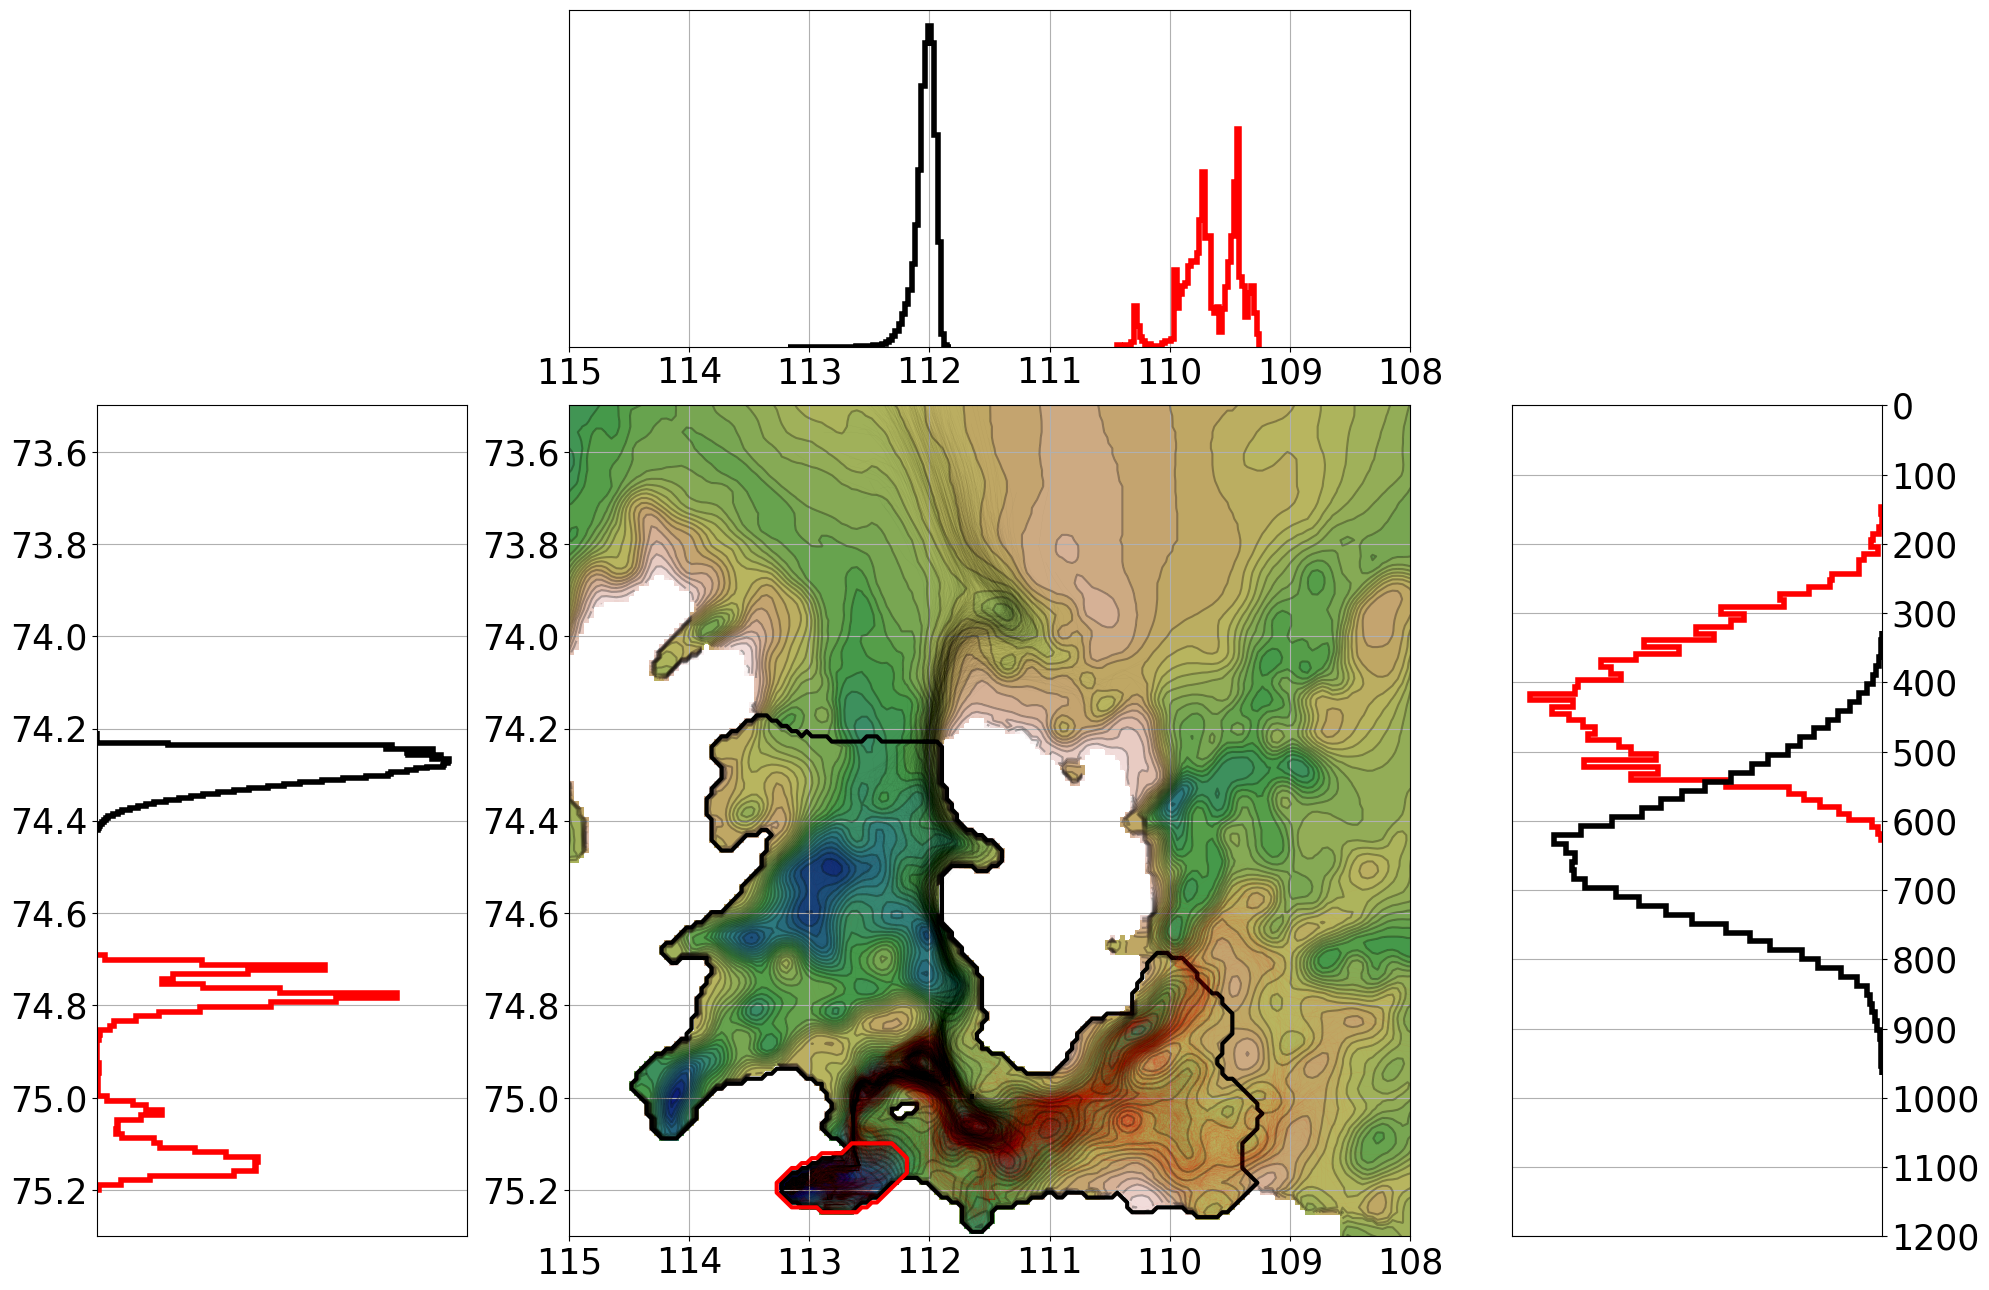

In [91]:
ls = 25
density = True

fig = plt.figure(figsize=(20, 13))

gs = gridspec.GridSpec(13, 16)
ax_main = plt.subplot(gs[4:, 4:12])
ax_xDist = plt.subplot(gs[0:4, 4:12],sharex=ax_main)
ax_yDist = plt.subplot(gs[4:13, :4],sharey=ax_main)
ax_zDist = plt.subplot(gs[4:13, 12:])

## Main Plot
ax_main.pcolormesh(XC, YC, bath, vmin=-1600, vmax=0, cmap='gist_earth')
ax_main.contourf(XC, YC, bath, levels=np.arange(-1601, 1, 50), cmap='gist_earth')
ax_main.contour(XC, YC, bath, levels=np.arange(-1601, 0, 50), colors=['k'], linestyles='solid', alpha=0.3, zorder=3)
ax_main.contour(XC, YC, mask, levels=[0,1], colors=['k'], linewidths=3)

ax_main.contour(XC, YC, csnmask, levels=[0,1], colors=['red'], linewidths=3, zorder=3)

ax_main.set_xticks([-115, -114, -113, -112, -111, -110, -109, -108])
ax_main.set_xticklabels([115, 114, 113, 112, 111, 110, 109, 108])

ax_main.set_yticks([-75.2, -75, -74.8, -74.6, -74.4, -74.2, -74.0, -73.8, -73.6])
ax_main.set_yticklabels([75.2, "75.0", 74.8, 74.6, 74.4, 74.2, "74.0", 73.8, 73.6])

ax_main.set_xlim(-115, -108)
ax_main.set_ylim(-75.3, -73.5)


ax_main.tick_params(axis='both', labelsize=ls)
ax_main.grid()

    

###
slon = lon[classify==2]
slat = lat[classify==2]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)


for c in tqdm(range(len(index))):
    
    i = index[c]
    
    lx = slon[i][:]
    ly = slat[i][:]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='red', lw=0.05, alpha=0.2)
    

slon = lon[classify==1]
slat = lat[classify==1]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)

for c in tqdm(range(len(index))):
    
    i = index[c]
    
    lx = slon[i][:]
    ly = slat[i][:]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='k', lw=0.05, alpha=0.2)

    

sZ = Z2[classify==2]
_, _, _ = ax_zDist.hist(sZ, 
                        bins=50, alpha=1, histtype=u'step', ec='red', 
                        orientation='horizontal', linewidth=4, density = density)
sZ = Z2[classify==1]
_, _, _ = ax_zDist.hist(sZ, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='horizontal', linewidth=4, density = density)
ax_zDist.tick_params(axis='both', labelsize=ls)
ax_zDist.invert_xaxis()
ax_zDist.yaxis.set_label_position("right")
ax_zDist.yaxis.tick_right()
ax_zDist.set_yticks([0, -100, -200, -300, -400, -500, -600, -700, -800, -900, -1000, -1100, -1200])
ax_zDist.set_yticklabels([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
ax_zDist.set_xticks([])
ax_zDist.grid()

sY = Y2[classify==2]
_, _, _ = ax_yDist.hist(sY, 
                        bins=50, alpha=1, histtype=u'step', ec='red', 
                        orientation='horizontal', linewidth=4, density = density)

sY = Y2[classify==1]
_, _, _ = ax_yDist.hist(sY, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='horizontal', linewidth=4, density = density)
ax_yDist.tick_params(axis='both', labelsize=ls)
ax_yDist.set_xticks([])
ax_yDist.grid()

sX = X2[classify==2]
_, _, _ = ax_xDist.hist(sX, 
                        bins=50, alpha=1, histtype=u'step', ec='red', 
                        orientation='vertical', linewidth=4, density = density)
sX = X2[classify==1]
_, _, _ = ax_xDist.hist(sX, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='vertical', linewidth=4, density = density)

ax_xDist.tick_params(axis='both', labelsize=ls)
ax_xDist.set_yticks([])
ax_xDist.grid()

plt.tight_layout()

plt.savefig('img_cavity_paths/Smith_Norm.png', dpi=300)

In [39]:
lon_loc = get('outputs/R8_ASE_5min/smith.zarr',
             'lon',
             'processed_dataGL/smith_0d_IS.npy')

lat_loc = get('outputs/R8_ASE_5min/smith.zarr',
             'lat',
             'processed_dataGL/smith_0d_IS.npy')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376980/376980 [03:53<00:00, 1611.44it/s]


In [41]:
classify = []

for i in range(len(lon_loc)):
    if np.isnan(lon_loc[i]):
        classify.append(np.nan)
    elif lon_loc[i] < -111:
        classify.append(1)
    else:
        classify.append(2)

classify = np.asarray(classify)

In [42]:
flush1, rate1 = calc_cavity_flushing(paths = 'processed_dataGL/smith_0d_IS.npy',
                   stucked = 'processed_dataGL/smith_0d_Stucked_incavity.npy',
                filt = classify,
                IS = 'processed_dataGL/smith_0d_IS.npy',
                                    filt_val = 1)

flush2, rate2 = calc_cavity_flushing(paths = 'processed_dataGL/smith_0d_IS.npy',
                   stucked = 'processed_dataGL/smith_0d_Stucked_incavity.npy',
                filt = classify,
                IS = 'processed_dataGL/smith_0d_IS.npy',
                                    filt_val = 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 241.73it/s]


Fastest 5% = 30.048907103825137 +- 5.462443698135911
Median = 58.69398907103825 +- 9.570521506246141
Slowest 5% = 271.5699726775955 +- 39.80992068532582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 278.10it/s]

Fastest 5% = 91.03934426229509 +- 37.79047872983508
Median = 159.51502732240436 +- 47.06087405771121
Slowest 5% = 355.173606557377 +- 99.5036634473915


In [44]:
_, _ = calc_cavity_flushing(paths = 'processed_dataGL/smith_0d_IS.npy',
                   stucked = 'processed_dataGL/smith_0d_Stucked.npy',
                filt = None,
                IS = 'processed_dataGL/smith_0d_IS.npy')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 231.55it/s]

Fastest 5% = 30.1922131147541 +- 5.500943860237914
Median = 59.362021857923494 +- 9.659048548532624
Slowest 5% = 286.0269398907103 +- 40.38332054286055


In [45]:
rmean1 = np.mean(rate1, axis=0)
rstd1 = np.std(rate1, axis=0)
fmean1 = np.mean(flush1, axis=0)
fstd1 = np.std(flush1, axis=0)

print(f'% of total particles that exited: {fmean1[-1]} +- {fstd1[-1]}')

rmean2 = np.mean(rate2, axis=0)
rstd2 = np.std(rate2, axis=0)
fmean2 = np.mean(flush2, axis=0)
fstd2 = np.std(flush2, axis=0)

print(f'% of total particles that exited: {fmean2[-1]} +- {fstd2[-1]}')


% of total particles that exited: 97.81968193048355 +- 1.1307195999450468
% of total particles that exited: 2.180318069516407 +- 1.1307195999450468


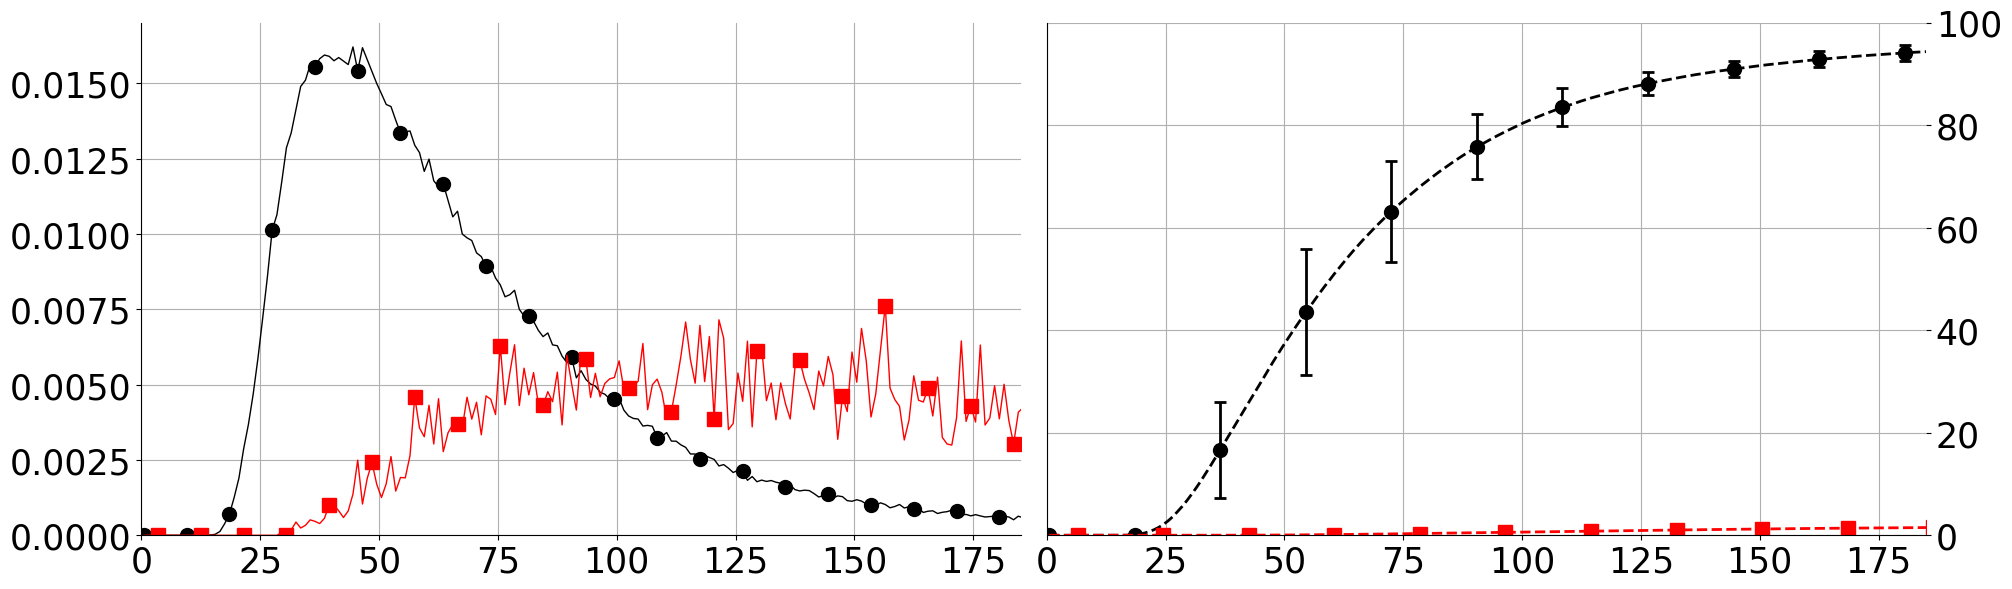

In [46]:
fig, ax = plt.subplots(figsize=(20,6), ncols=2)


ax[0].plot(np.arange(0.5, 364, 1),
        rmean1[:364]/np.sum(rmean1[:364]), '-k', lw=1, marker='o', ms=10, markevery=(0,9))
ax[0].plot(np.arange(0.5, 364, 1),
        rmean2[:364]/np.sum(rmean2[:364]), '-r', lw=1, marker='s', ms=10, markevery=(3,9))

ax[1].errorbar(np.arange(0.5, 364, 1),
             fmean1[:364], fmt = '--k',
             yerr=fstd1[:364]/1,
            errorevery = (18),ecolor='k',marker='o', markevery=(18), ms=10, capsize=4, capthick=2, linewidth=2)

ax[1].errorbar(np.arange(0.5, 364, 1),
             fmean2[:364], fmt = '--r',
             yerr=fstd2[:364]/1,
            errorevery = (6,18),ecolor='red',marker='s', markevery=(6,18),ms=10, capsize=4, capthick=2, linewidth=2)

# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean1[:364], c= 'red')
# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean2[:364], c='blue')
# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean3[:364], c='k')


ax[0].set_ylim(0)
ax[1].set_ylim(0)
ax[0].set_xlim(0, 185)
ax[1].set_xlim(0, 185)
ax[1].set_ylim(0,100)

ax[1].yaxis.tick_right()

for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.grid()
    a.tick_params(axis='both', labelsize=ls)
    
plt.tight_layout()

plt.savefig('img_cavity_paths/Smith_Time.png', dpi=300)

# Kohler

In [92]:
# tindex, lon, lat, depth = get_vals(zarr_path = 'outputs/R8_ASE_5min/kohler.zarr',
#                                          exit_index_path = 'processed_dataGL/kohler_0d_IS.npy')

# np.save("processed_exit_cavity/kohler_T.npy", tindex)
# np.save("processed_exit_cavity/kohler_X.npy", lon)
# np.save("processed_exit_cavity/kohler_Y.npy", lat)
# np.save("processed_exit_cavity/kohler_Z.npy", depth)

tindex = np.load("processed_exit_cavity/kohler_T.npy", allow_pickle=True)
lon = np.load("processed_exit_cavity/kohler_X.npy", allow_pickle=True)
lat = np.load("processed_exit_cavity/kohler_Y.npy", allow_pickle=True)
depth = np.load("processed_exit_cavity/kohler_Z.npy", allow_pickle=True)

In [93]:
Z = [i[-10] for i in depth]
T = [i for i in tindex]
X = [i[-10] for i in lon]
Y = [i[-10] for i in lat]
X2 = np.asarray([i[-11] for i in lon])
Y2 = np.asarray([i[-11] for i in lat])
Z2 = np.asarray([i[-11] for i in depth])

In [94]:
np.nanmean(X2), np.nanmean(Y2), np.nanmean(Z2)

(-112.06396331129876, -74.28994367879508, -690.6086211788651)

In [95]:
finalZ = [i[0] for i in depth]
np.mean(finalZ)

-1171.3154187936066

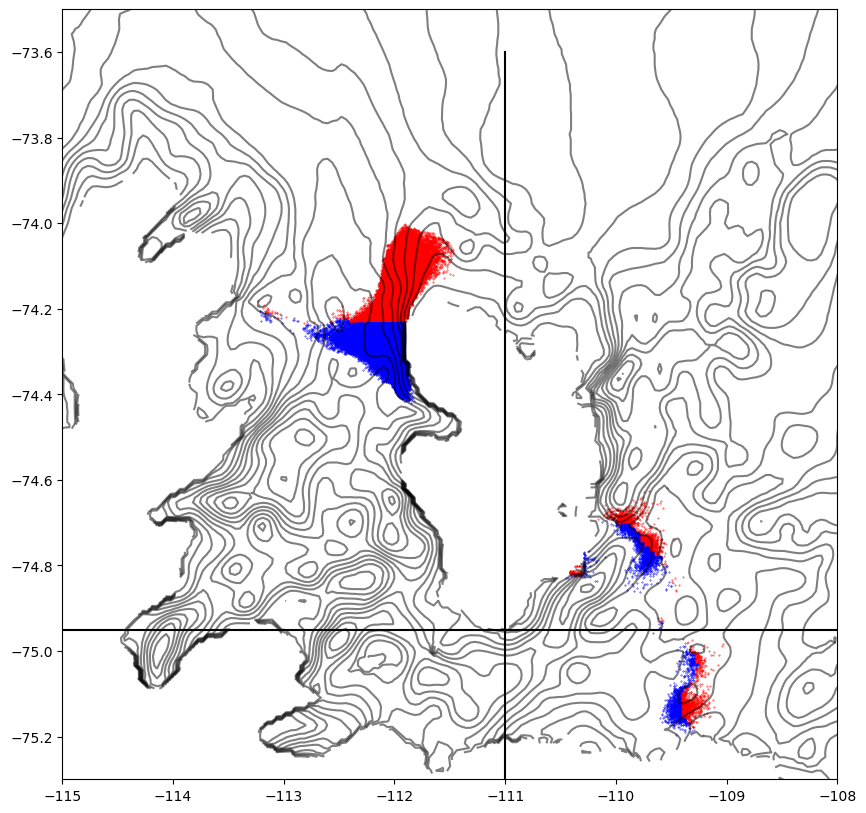

In [96]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(X, Y, s=0.1, c='red')

ax.scatter(X2, Y2, s=0.1, c='blue')

ax.contour(XC, YC, bath, levels=np.arange(-1600, 0, 100), colors=['k'], linestyles='solid', alpha=0.5, zorder=3)

ax.set_xlim(-115, -108)
ax.set_ylim(-75.3, -73.5)

ax.plot([-111, -111], [-75.3, -73.6], c='k')
ax.plot([-115, -108], [-74.95, -74.95], c='k')
# ax.plot([-109, -104], [-74.9, -74.9], c='k')

In [97]:
mask = np.load('inputs/ref/CSN_Mask.npy')
csnmask = np.load('csn_mask.npy')
csnmask[:38, :] = 0

In [98]:
classify = []

for i in range(len(Y)):
    if X[i] < -111:
        classify.append(1)
    else:
        classify.append(2)

classify = np.asarray(classify)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2044.64it/s]


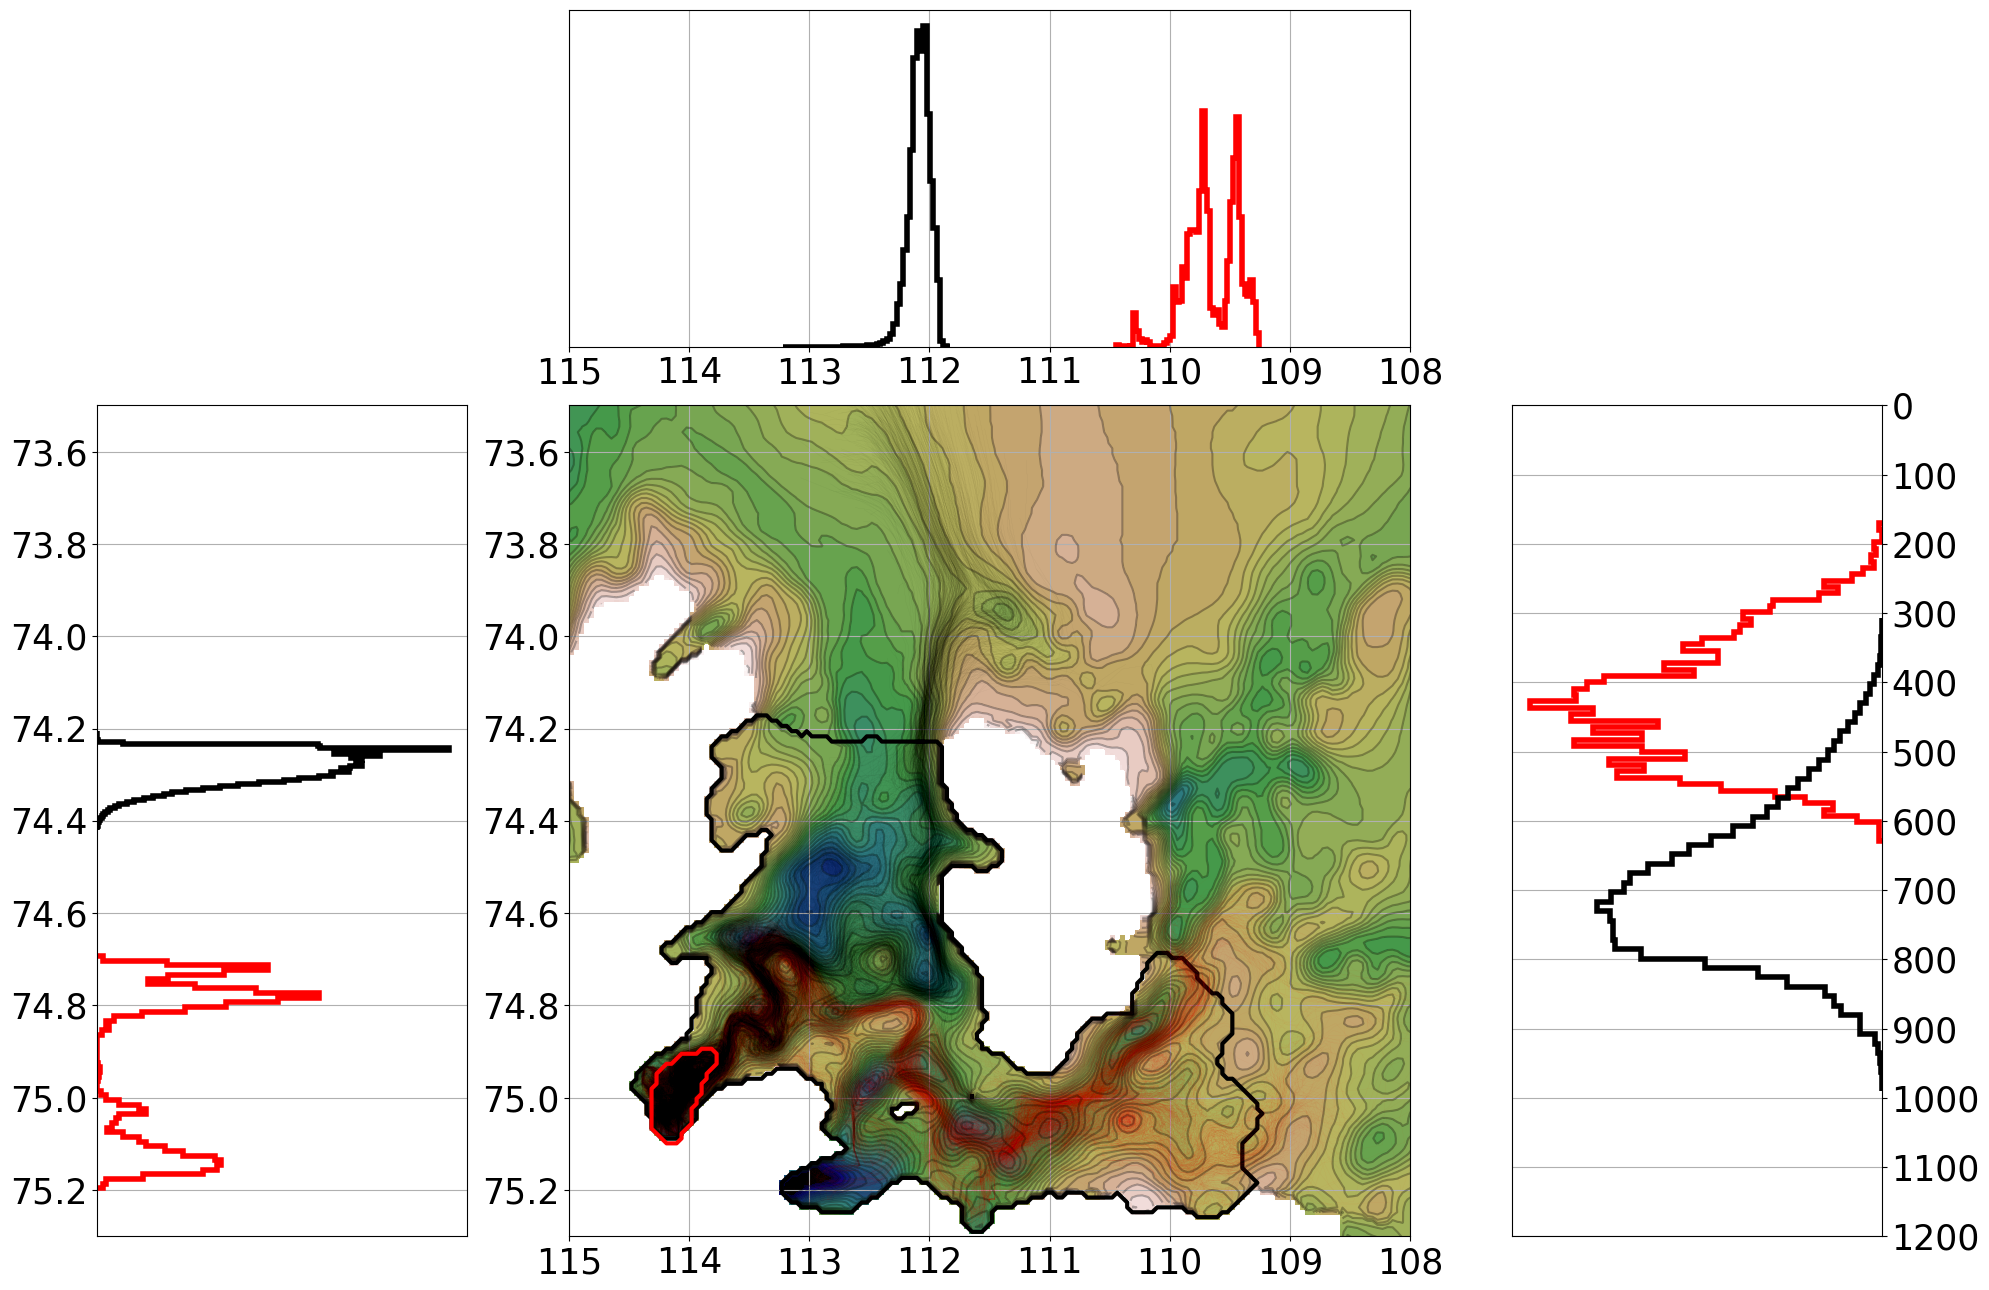

In [99]:
ls = 25
density = True

fig = plt.figure(figsize=(20, 13))

gs = gridspec.GridSpec(13, 16)
ax_main = plt.subplot(gs[4:, 4:12])
ax_xDist = plt.subplot(gs[0:4, 4:12],sharex=ax_main)
ax_yDist = plt.subplot(gs[4:13, :4],sharey=ax_main)
ax_zDist = plt.subplot(gs[4:13, 12:])

## Main Plot
ax_main.pcolormesh(XC, YC, bath, vmin=-1600, vmax=0, cmap='gist_earth')
ax_main.contourf(XC, YC, bath, levels=np.arange(-1601, 1, 50), cmap='gist_earth')
ax_main.contour(XC, YC, bath, levels=np.arange(-1601, 1, 50), colors=['k'], linestyles='solid', alpha=0.3, zorder=3)
ax_main.contour(XC, YC, mask, levels=[0,1], colors=['k'], linewidths=3)

ax_main.contour(XC, YC, csnmask, levels=[0,1], colors=['red'], linewidths=3, zorder=3)

ax_main.set_xticks([-115, -114, -113, -112, -111, -110, -109, -108])
ax_main.set_xticklabels([115, 114, 113, 112, 111, 110, 109, 108])

ax_main.set_yticks([-75.2, -75, -74.8, -74.6, -74.4, -74.2, -74.0, -73.8, -73.6])
ax_main.set_yticklabels([75.2, "75.0", 74.8, 74.6, 74.4, 74.2, "74.0", 73.8, 73.6])

ax_main.set_xlim(-115, -108)
ax_main.set_ylim(-75.3, -73.5)


ax_main.tick_params(axis='both', labelsize=ls)
ax_main.grid()

    

###
slon = lon[classify==2]
slat = lat[classify==2]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)


for c in tqdm(range(len(index))):
    
    i = index[c]
    
    lx = slon[i][:]
    ly = slat[i][:]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='red', lw=0.05, alpha=0.2)
    

### 
slon = lon[classify==1]
slat = lat[classify==1]
index = np.random.choice([i for i in range(len(slon))], size=1000, replace=False)


for c in tqdm(range(len(index))):
    
    i = index[c]
    
    lx = slon[i][:]
    ly = slat[i][:]
    c = np.arange(len(lx))

    ax_main.plot(lx, ly, color='k', lw=0.02, alpha=0.5)

    

sZ = Z2[classify==2]
_, _, _ = ax_zDist.hist(sZ, 
                        bins=50, alpha=1, histtype=u'step', ec='red', 
                        orientation='horizontal', linewidth=4, density = density)
sZ = Z2[classify==1]
_, _, _ = ax_zDist.hist(sZ, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='horizontal', linewidth=4, density = density)
ax_zDist.tick_params(axis='both', labelsize=ls)
ax_zDist.invert_xaxis()
ax_zDist.yaxis.set_label_position("right")
ax_zDist.yaxis.tick_right()
ax_zDist.set_yticks([0, -100, -200, -300, -400, -500, -600, -700, -800, -900, -1000, -1100, -1200])
ax_zDist.set_yticklabels([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
ax_zDist.set_xticks([])
ax_zDist.grid()


sY = Y2[classify==2]
_, _, _ = ax_yDist.hist(sY, 
                        bins=50, alpha=1, histtype=u'step', ec='red', 
                        orientation='horizontal', linewidth=4, density = density)

sY = Y2[classify==1]
_, _, _ = ax_yDist.hist(sY, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='horizontal', linewidth=4, density = density)
ax_yDist.tick_params(axis='both', labelsize=ls)
ax_yDist.set_xticks([])
ax_yDist.grid()


sX = X2[classify==2]
_, _, _ = ax_xDist.hist(sX, 
                        bins=50, alpha=1, histtype=u'step', ec='red', 
                        orientation='vertical', linewidth=4, density = density)
sX = X2[classify==1]
_, _, _ = ax_xDist.hist(sX, 
                        bins=50, alpha=1, histtype=u'step', ec='k', 
                        orientation='vertical', linewidth=4, density = density)

ax_xDist.tick_params(axis='both', labelsize=ls)
ax_xDist.set_yticks([])
ax_xDist.grid()

plt.tight_layout()

plt.savefig('img_cavity_paths/Kohler_Norm.png', dpi=300)

In [53]:
lon_loc = get('outputs/R8_ASE_5min/kohler.zarr',
             'lon',
             'processed_dataGL/kohler_0d_IS.npy')

lat_loc = get('outputs/R8_ASE_5min/kohler.zarr',
             'lat',
             'processed_dataGL/kohler_0d_IS.npy')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365268/365268 [04:18<00:00, 1411.34it/s]


In [54]:
classify = []

for i in range(len(lon_loc)):
    if np.isnan(lon_loc[i]):
        classify.append(np.nan)
    elif lon_loc[i] < -111:
        classify.append(1)
    else:
        classify.append(2)

classify = np.asarray(classify)

In [55]:
flush1, rate1 = calc_cavity_flushing(paths = 'processed_dataGL/kohler_0d_IS.npy',
                   stucked = 'processed_dataGL/kohler_0d_Stucked.npy',
                filt = classify,
                IS = 'processed_dataGL/kohler_0d_IS.npy',
                filt_val = 1)

flush2, rate2 = calc_cavity_flushing(paths = 'processed_dataGL/kohler_0d_IS.npy',
                   stucked = 'processed_dataGL/kohler_0d_Stucked.npy',
                filt = classify,
                IS = 'processed_dataGL/kohler_0d_IS.npy',
                filt_val = 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 251.62it/s]


Fastest 5% = 58.588251366120225 +- 11.89963888886755
Median = 115.89480874316939 +- 15.405644425166955
Slowest 5% = 361.1818579234972 +- 27.81106365415464


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 282.46it/s]

Fastest 5% = 167.25766016713092 +- 72.83464562199592
Median = 223.6142061281337 +- 70.28297989817294
Slowest 5% = 384.12481894150415 +- 111.74693669956245



/tmp/ipykernel_3149705/3185724206.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(flush), np.asarray(rates)


In [56]:
_, _ = calc_cavity_flushing(paths = 'processed_dataGL/kohler_0d_IS.npy',
                   stucked = 'processed_dataGL/kohler_0d_Stucked.npy',
                filt = None,
                IS = 'processed_dataGL/kohler_0d_IS.npy')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 233.91it/s]

Fastest 5% = 58.657650273224036 +- 11.88831377087809
Median = 116.4139344262295 +- 15.332341878236017
Slowest 5% = 367.35691256830586 +- 28.537335922623555


In [57]:
rmean1 = np.mean(rate1, axis=0)
rstd1 = np.std(rate1, axis=0)
fmean1 = np.mean(flush1, axis=0)
fstd1 = np.std(flush1, axis=0)

print(f'% of total particles that exited: {fmean1[-1]} +- {fstd1[-1]}')

rmean2 = np.mean(rate2, axis=0)
rstd2 = np.std(rate2, axis=0)
fmean2 = np.mean(flush2, axis=0)
fstd2 = np.std(flush2, axis=0)

print(f'% of total particles that exited: {fmean2[-1]} +- {fstd2[-1]}')


% of total particles that exited: 99.11390555000224 +- 0.636603122134465
% of total particles that exited: 0.88609444999772 +- 0.6366031221344645


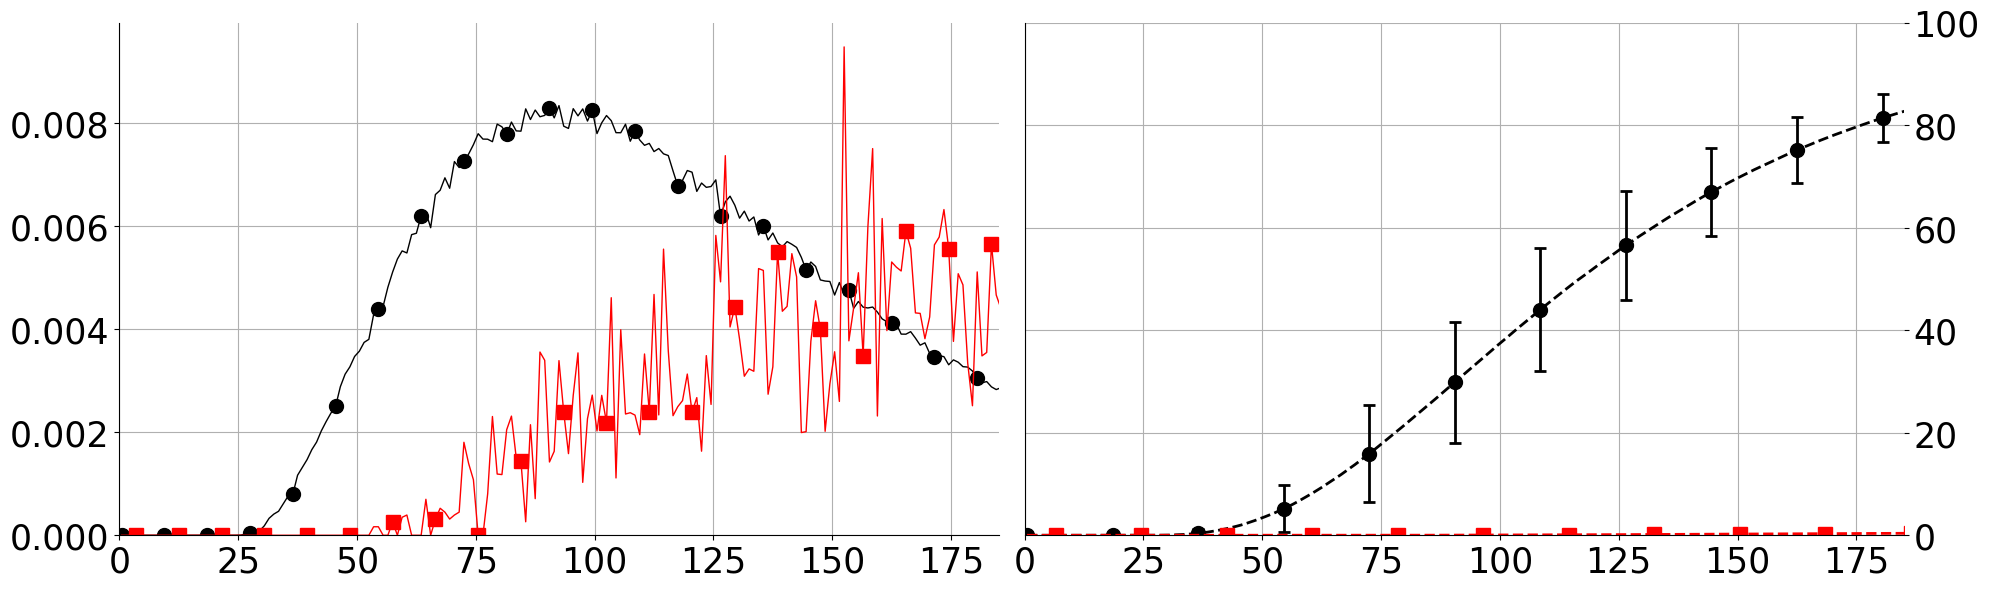

In [58]:
fig, ax = plt.subplots(figsize=(20,6), ncols=2)


ax[0].plot(np.arange(0.5, 364, 1),
        rmean1[:364]/np.sum(rmean1[:364]), '-k', lw=1, marker='o', ms=10, markevery=(0,9))
ax[0].plot(np.arange(0.5, 364, 1),
        rmean2[:364]/np.sum(rmean2[:364]), '-r', lw=1, marker='s', ms=10, markevery=(3,9))



ax[1].errorbar(np.arange(0.5, 364, 1),
             fmean1[:364], fmt = '--k',
             yerr=fstd1[:364]/1,
            errorevery = (18),ecolor='k',marker='o', markevery=(18), ms=10, capsize=4, capthick=2, linewidth=2)

ax[1].errorbar(np.arange(0.5, 364, 1),
             fmean2[:364], fmt = '--r',
             yerr=fstd2[:364]/1,
            errorevery = (6,18),ecolor='red',marker='s', markevery=(6,18),ms=10, capsize=4, capthick=2, linewidth=2)

# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean1[:364], c= 'red')
# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean2[:364], c='blue')
# ax[1].plot(np.arange(0.5, 364, 1),
#        fmean3[:364], c='k')


ax[0].set_ylim(0)
ax[1].set_ylim(0)
ax[0].set_xlim(0, 185)
ax[1].set_xlim(0, 185)
ax[1].set_ylim(0,100)

ax[1].yaxis.tick_right()

for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.grid()
    a.tick_params(axis='both', labelsize=ls)
    
plt.tight_layout()

plt.savefig('img_cavity_paths/Kohler_Time.png', dpi=300)